In [1]:
import torch
import spacy
import numpy as np
import torchtext.vocab
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchtext import data
from transformers import BertTokenizer
import torch
import torch.nn as nn
from sentiment_model.data_utils.tweet_dataset import TweetDataset, pad_batch
from sentiment_model.evaluation import run_evaluation
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import os
from utils import get_project_root
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sentiment_model.model_calibration import plot_calib_curve, CalibratedModel

In [2]:
preds, targets, model = run_evaluation(model_file="lemon-forest-81/lemon-forest-81-epoch-1.pth", num_classes=2,
                                dataset="sent140_multi_class")

# Import GloVe Embeddings
# Load training dataset to build vocab
cache_path = os.path.join(get_project_root(), Path("sentiment_model/.vector_cache/"))
glove_twitter = GloVe(name="twitter.27B", dim=50, cache=cache_path)

# Instantiate vectors and ensure a 0 vector is inserted for unknown characters and padded characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(2, pre_embeds.shape[1]), pre_embeds))

# Load data:
valid_dataset = TweetDataset(split="valid", dataset="sent140_multi_class", pretrained_vecs=glove_twitter)
valid_y = [y for _, y in valid_dataset]

Reusing dataset sentiment140 (C:\Users\20172613\.cache\huggingface\datasets\sentiment140\sentiment140\1.0.0\f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

Reusing dataset sentiment140 (C:\Users\20172613\.cache\huggingface\datasets\sentiment140\sentiment140\1.0.0\f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
preds = model.predict_proba(valid_dataset)

In [ ]:
CM = CalibratedModel(model)
CM.fit(valid_dataset, valid_y)

In [ ]:
pred_calib = CM.predict_proba(valid_dataset)

In [ ]:
plot_calib_curve(valid_y, preds[:,1], pred_calib[:,1])

In [4]:
def plot_calib_curve(y_true, y_pred_prob, y_pred_prob_calib=None, bins=20):
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,10), gridspec_kw={'height_ratios':[3,1]})
    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=bins)

    ax[0].plot([0,1], [0, 1], "k:", label="Perfectly calibrated")
    ax[0].plot(prob_pred, prob_true, "s-", label="Non-calibrated model")
    ax[0].set_ylabel("Fraction Positives")
    ax[0].set_xlabel("Mean predicted probability")

    if y_pred_prob_calib is not None:
        prob_true, prob_pred_calib = calibration_curve(y_true, y_pred_prob_calib, n_bins=bins)
        ax[0].plot(prob_true, prob_pred_calib, "s-", label="Calibrated model")

    ax[0].set_ylim([-0.05, 1.05])
    ax[0].legend(loc="lower right")

    ax[1].hist(y_pred_prob, range=(0,1), bins=20, histtype="step", lw=2, label="Non-calibrated model")

    if y_pred_prob_calib is not None:
        ax[1].hist(y_pred_prob_calib, range=(0,1), bins=20, histtype="step", lw=2, label="Calibrated model")
        ax[1].legend()

    ax[1].set_xlabel("Mean predicted probability")
    ax[1].set_ylabel("Count")
    return

In [6]:
class CalibratedModel:
    def __init__(self, model):
        self.model = model
        self.fitted = False
        self.calibrator = LogisticRegression()

    def fit(self, X, y):
        pred_prob = model.predict_proba(X)
        y_multi = np.array(y) + 1
        self.calibrator.fit(pred_prob, y_multi)
        self.fitted = True

    def predict_proba(self, X):
        if not self.fitted:
            raise Exception("Calibrator not fitted!")

        model_preds = model.predict_proba(X)
        return self.calibrator.predict_proba(model_preds)

    def predict(self, X):
        if not self.fitted:
            raise Exception("Calibrator not fitted!")

        model_preds = model.predict_proba(X)
        return self.calibrator.predict(model_preds)

In [7]:
CM = CalibratedModel(model)
CM.fit(valid_dataset, valid_y)
pred_calib = CM.predict_proba(valid_dataset)
preds = model.predict_proba(valid_dataset)


KeyboardInterrupt: 

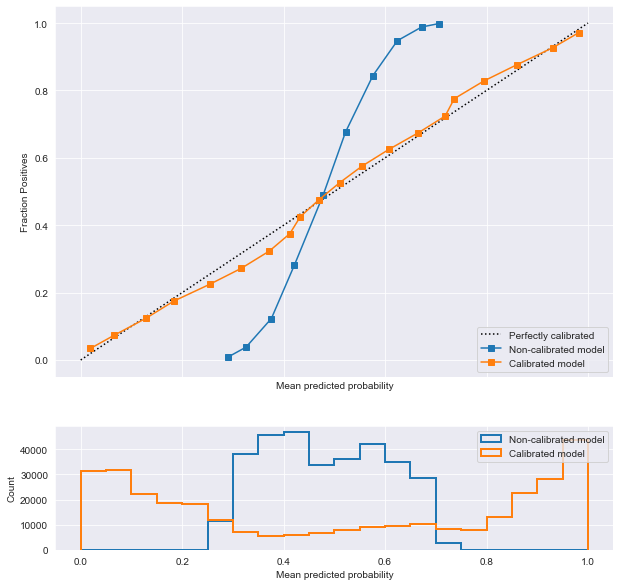

In [30]:
plot_calib_curve(valid_y, preds[:,1], pred_calib[:,1])

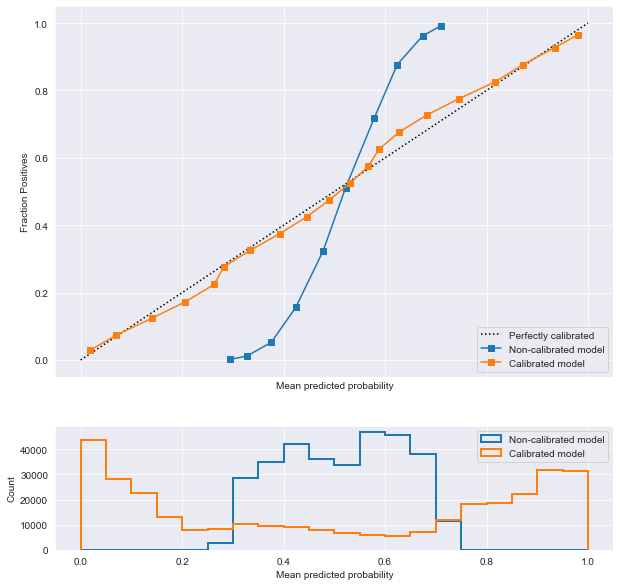

In [31]:
plot_calib_curve((np.array(valid_y) == 0).astype(int), valid_pred[:,0], calibrator.predict_proba(valid_pred)[:,0])

In [4]:
sent140_data = load_dataset("sentiment140")

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/739 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sentiment140 downloaded and prepared to C:\Users\20172613\.cache\huggingface\datasets\sentiment140\sentiment140\1.0.0\f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
np.unique(sent140_data['test']['sentiment'])

array([0, 2, 4])

In [34]:
np.sum(np.array(sent140_data['test']['sentiment']) == 2)/len(sent140_data['test'])

0.2791164658634538

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Import GloVe Embeddings
glove_twitter = GloVe(name="twitter.27B", dim=50)
tweet_data = load_dataset("SetFit/tweet_sentiment_extraction")
tweet_dataset = TweetDataset(split='train', pretrained_vecs=glove_twitter)
# Instantiate vectors and ensure a 0 vector is inserted for unknown characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(2, pre_embeds.shape[1]), pre_embeds))
embedding = nn.Embedding.from_pretrained(pre_embeds, sparse=True, padding_idx=0)


Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
tweet_dataset[88]

(tensor([    1,   195,     6,     1,   357,     3,    12,   427,    47,  3731,
           802,   455,    81,   234, 10786,    18,  1852,   565,     3,    57,
           719,    35,     1,   126,   357,   126,   109,  2297,    16]),
 0)

In [4]:
tk = get_tokenizer("spacy", language="en_core_web_sm")
tk

functools.partial(<function _spacy_tokenize at 0x000001B1EBF49C10>, spacy=<spacy.lang.en.English object at 0x000001B1FF282FA0>)

In [4]:
tweet_dataset.text_pipeline("@sup_dude hello/hi <hashtag>d #hello :-)))")

[2, 998, 40, 591, 73, 4331, 62, 201, 8, 998, 25]

In [18]:
tk("@sup_dude hello/hi <hashtag>d #hello :-)))")

['@sup_dude',
 'hello',
 '/',
 'hi',
 '<',
 'hashtag',
 '>',
 'd',
 '#',
 'hello',
 ':-)))']

In [10]:
tweet_data['train']['text']

[' I`d have responded, if I were going',
 ' Sooo SAD I will miss you here in San Diego!!!',
 'my boss is bullying me...',
 ' what interview! leave me alone',
 ' Sons of ****, why couldn`t they put them on the releases we already bought',
 'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth',
 '2am feedings for the baby are fun when he is all smiles and coos',
 'Soooo high',
 ' Both of you',
 ' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)',
 ' as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff',
 'I really really like the song Love Story by Taylor Swift',
 'My Sharpie is running DANGERously low on ink',
 'i want to go to music tonight but i lost my voice.',
 'test test from the LG enV2',
 'Uh oh, I am sunburned',
 ' S`ok, trying to plot alternatives as we speak *sigh*',
 'i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on i

In [8]:
tk(tweet_data['train']['text'][5])

['http://www.dothebouncy.com/smf',
 '-',
 'some',
 'shameless',
 'plugging',
 'for',
 'the',
 'best',
 'Rangers',
 'forum',
 'on',
 'earth']

In [3]:
glove_twitter = GloVe(name="twitter.27B", dim=50)

# Instantiate vectors and ensure a 0 vector is inserted for unknown characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(1, pre_embeds.shape[1]), pre_embeds))

# Load data:
train_dataset = TweetDataset(split="train", pretrained_vecs=glove_twitter)
valid_dataset = TweetDataset(split="valid", pretrained_vecs=glove_twitter)

# Create data loaders:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
train_dataset[0]

(tensor([3059,  129,  217, 2506]), 1)

In [18]:
next(iter(train_loader))[0][1,:]

tensor([   0, 6516,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [8]:
embedding.weight[998]

tensor([ 0.2875,  0.3132, -0.2932,  0.1720, -0.6923, -0.4593,  1.3364,  0.7090,
         0.1212,  0.1148, -0.4850, -0.0886, -3.0154, -0.5402, -1.3260,  0.3948,
         0.1176, -0.1782, -0.3227,  0.2172,  0.0431, -0.4367, -0.5586, -0.4760,
        -0.0952,  0.0032,  0.1192, -0.2364,  1.3234, -0.4509, -0.6584, -0.1387,
         0.2215, -0.3581,  0.2099,  0.0549, -0.0803,  0.4894,  0.1921,  0.4556,
        -1.6420, -0.8332, -0.1297,  0.9651, -0.1821,  0.3773, -0.1962, -0.1223,
        -0.1050,  0.4539])

In [11]:
tweet_dataset.vocab["<pad>"]
#tweet_dataset.vocab.lookup_token(6516)

0

In [18]:
from sentiment_model.model import SentimentNet
from sentiment_model.data_utils.tweet_dataset import pad_batch

train_loader = DataLoader(tweet_dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)
len(tweet_dataset.vocab)

model = SentimentNet()
model_state_dict = torch.load("checkpoints/cool-bee-4/cool-bee-4-epoch-11.pth")['model_state_dict']
model.load_state_dict(model_state_dict)
data, target, text_lengths = next(iter(train_loader))

In [54]:
tweet_dataset.vocab['Hello']

tz = get_tokenizer("spacy", language="en_core_web_sm")
tweet_dataset.vocab['asfj;lsadj;lasdjf']


RuntimeError: Token asfj;lsadj;lasdjf not found and default index is not set

In [46]:
tz("Helllooo how. lkjadf; are yuou\?")

['Helllooo', 'how', '.', 'lkjadf', ';', 'are', 'yuou\\', '?']

In [74]:
from torchtext. vocab import GloVe, vocab

tokens = tz("Helllooo how. lkjadf; are yuou\?".lower())

glove_twitter = GloVe(name = "twitter.27B", dim=50)

In [101]:
glove_twitter.get_vecs_by_tokens()

tensor([-0.4722,  0.6159, -0.6601, -0.1462, -0.4797, -0.5676,  0.4519,  0.4646,
        -0.2835, -0.6584,  0.3741, -0.6437, -3.3311,  0.3133,  0.2019,  0.1715,
         0.6436,  0.2090,  0.0325, -0.1899, -0.8975,  0.9616, -0.2340, -0.4361,
         0.0687, -0.8583,  0.0737, -0.1705,  0.5671,  0.0952, -0.1938, -0.3952,
         0.1049, -0.2117, -1.0626,  0.4975,  0.0692,  0.2275,  0.0324, -0.6410,
        -0.5017,  0.0518,  0.3308,  0.7859,  1.3322, -0.0709,  0.6726,  0.2338,
        -0.7912, -0.6818])

In [90]:
glove_vocab = vocab(glove_twitter.stoi)
unk_token = "<unk>"
unk_index = 0
glove_vocab.insert_token(unk_token, unk_index)
glove_vocab.set_default_index(unk_index)


1193514

In [99]:
a = torch.tensor([1,2,3])
if a is not None:
    print("Yes")

Yes


In [29]:
tz = BertTokenizer.from_pretrained('bert-base-uncased')
print(tz.ids_to_tokens[0])

[PAD]
